In [1]:
import cv2
import numpy as np
import operator
from matplotlib import pyplot as plt

from utils import *
from constants import *
from preprocessing import *
from plots import *

from sklearn.metrics import accuracy_score, precision_score, f1_score

# pyeer library: pip install pyeer
from pyeer.eer_info import get_eer_stats
from pyeer.report import generate_eer_report, export_error_rates
from pyeer.plot import plot_eer_stats

In [2]:
image_files = read_images()

In [5]:
train_set, test_set = prepare_dataset(image_files)

Processing image 101_1.tif ...  
Processing image 101_2.tif ...  
Processing image 101_3.tif ...  
Processing image 101_4.tif ...  
Processing image 101_5.tif ...  
Processing image 101_6.tif ...  
Processing image 101_7.tif ...  
Processing image 101_8.tif ...  
Processing image 102_1.tif ...  
Processing image 102_2.tif ...  
Processing image 102_3.tif ...  
Processing image 102_4.tif ...  
Processing image 102_5.tif ...  
Processing image 102_6.tif ...  
Processing image 102_7.tif ...  
Processing image 102_8.tif ...  
Processing image 103_1.tif ...  
Processing image 103_2.tif ...  
Processing image 103_3.tif ...  
Processing image 103_4.tif ...  
Processing image 103_5.tif ...  
Processing image 103_6.tif ...  
Processing image 103_7.tif ...  
Processing image 103_8.tif ...  
Processing image 104_1.tif ...  
Processing image 104_2.tif ...  
Processing image 104_3.tif ...  
Processing image 104_4.tif ...  
Processing image 104_5.tif ...  
Processing image 104_6.tif ...  
Processing

* Checking the size of the training and test set. After the split of the dataset, there are 6 images per person (class) for train and 2 images for test.
* #### train_set and test_set represent lists of tuples, with the form: (img_label, img)

In [6]:
print('Size of the training set:', len(train_set))
print('Size of the test set:', len(test_set))

Size of the training set: 60
Size of the test set: 20


In [7]:
print(train_set.keys())

dict_keys(['101_1.tif', '101_8.tif', '101_3.tif', '101_5.tif', '101_4.tif', '101_7.tif', '102_1.tif', '102_8.tif', '102_3.tif', '102_5.tif', '102_4.tif', '102_7.tif', '103_1.tif', '103_8.tif', '103_3.tif', '103_5.tif', '103_4.tif', '103_7.tif', '104_1.tif', '104_8.tif', '104_3.tif', '104_5.tif', '104_4.tif', '104_7.tif', '105_1.tif', '105_8.tif', '105_3.tif', '105_5.tif', '105_4.tif', '105_7.tif', '106_1.tif', '106_8.tif', '106_3.tif', '106_5.tif', '106_4.tif', '106_7.tif', '107_1.tif', '107_8.tif', '107_3.tif', '107_5.tif', '107_4.tif', '107_7.tif', '108_1.tif', '108_8.tif', '108_3.tif', '108_5.tif', '108_4.tif', '108_7.tif', '109_1.tif', '109_8.tif', '109_3.tif', '109_5.tif', '109_4.tif', '109_7.tif', '110_1.tif', '110_8.tif', '110_3.tif', '110_5.tif', '110_4.tif', '110_7.tif'])


* #### Next, we plot one image before and after converting it to grayscale and appling enhancement.


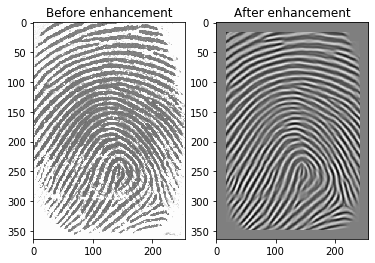

In [8]:
plt.subplot(1, 2, 1)
plt.title('Before enhancement')
img_fpr = cv2.imread(image_files[0])
plt.imshow(img_fpr, cmap='gray')
plt.subplot(1, 2, 2)
plt.title('After enhancement')
plt.imshow(train_set['101_1.tif'], cmap='gray')
plt.show()

- We define few methods used for the identification and authetication scenarios.

* ORB (Oriented FAST and Rotated BRIEF) descriptor is used to find matching keypoints. As a matching function we use number of matching features whose distance is below a given threshold.

In [9]:
# Initiate ORB detector for matching keypoints
orb = cv2.ORB_create(MAX_FEATURES)
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)

In [10]:
# Returns feature descripors for all images from the dataset
def get_feature_descriptors(dataset):
    feature_descriptors = {}
    for image_id, image in dataset.items():
        kp, des = orb.detectAndCompute(image, None)
        feature_descriptors[image_id] = des
    return feature_descriptors

In [11]:
# Returns best_matches between training features descriptors and query image
def get_best_matches(query_image, trained_features, distance_threshold): 
    best_matches_dict = {}
    kp1, query_des = orb.detectAndCompute(query_image, None) # features of the query image
    for train_image_id, trained_feature_des in trained_features.items():
        if query_des is not None and trained_feature_des is not None:
            matches = bf.match(query_des, trained_feature_des)
            matches.sort(key=lambda x: x.distance, reverse=False) # sort matches based on feature distance
            
            best_matches = [m.distance for m in matches if m.distance < distance_threshold]
            best_matches_dict[train_image_id] = len(best_matches) # matching function = length of best matches to given threshold
    
    best_matches_dict = sorted(best_matches_dict.items(), key = operator.itemgetter(1), reverse=True) # sort by value - feature distance
    return best_matches_dict

In [12]:
# Apply homography to test and train image
# Homography or image alignment: to perfectly line up the features in two images
def apply_homography(query_image, closest_image):
    kp1, des1 = orb.detectAndCompute(query_image, None)
    kp2, des2 = orb.detectAndCompute(closest_image, None)
    matches = bf.match(des1, des2)

    # Apply homography
    numGoodMatches = int(len(matches) * GOOD_MATCH_PERCENT)
    matches = matches[:numGoodMatches]

    src_pts = np.float32([kp1[m.queryIdx].pt for m in matches]).reshape(-1, 1, 2)
    dst_pts = np.float32([kp2[m.trainIdx].pt for m in matches]).reshape(-1, 1, 2)

    # M matrix that represents the homography
    M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)

    # Use homography
    height, width = query_image.shape[:2]
    # The function warpPerspective transforms the source image using the specified matrix
    im1Reg = cv2.warpPerspective(closest_image, M, (width, height))

    # Plot aligned query and train image
    plt.subplot(1, 2, 1)
    plt.imshow(im1Reg, cmap='gray')
    plt.subplot(1, 2, 2)
    plt.imshow(query_image, cmap='gray')
    plt.show()

In [13]:
from collections import defaultdict

def classify_fpr(best_matches_dict, rank):
    '''
    Counts how many fprs from the same class are there in the first ranked 
    :param feature_distances: Feature distaces from given query fpr to all training fprs
    :param rank: To take the first ranked closest features
    :return first_rank_sorted: dictionary, where key denotes the fpr class and 
            the value is how many times it appears in the first ranked fprs
    '''
    first_rank_fprs = defaultdict(int)
    for fpr_name, distance in best_matches_dict[0:rank]:
        fpr_class = get_image_class(fpr_name)
        first_rank_fprs[fpr_class] += 1
            
    first_rank_sorted = sorted(first_rank_fprs.items(), key = operator.itemgetter(1), reverse=True) 
    return first_rank_sorted

In [14]:
def draw_keypoints_matches(fpr1, fpr2):
    kp1, des1 = orb.detectAndCompute(fpr1, None) 
    kp2, des2 = orb.detectAndCompute(fpr2, None)

    matches = bf.match(des1, des2)
    matches.sort(key=lambda x: x.distance, reverse=False)
    imMatches = cv2.drawMatches(fpr1, kp1, fpr2, kp2,matches[:10], None)

    plt.imshow(imMatches)
    plt.show()

* ## Identification scenario

First we analyse the identificaion scenario, which corresponds to 1:M clasification problem. Biometric identification answers the question “Who are you?”. It is usually applied in a situation where an organization needs to identify a person. The organization captures a biometric from that individual and then searches in a database in order to correctly identify the person. [2]

In [15]:
train_feature_descriptors = get_feature_descriptors(train_set)

In [16]:
np.sum(1*((255*train_set["107_7.tif"])==1))

1

In [17]:
# Definition of identification scenario
def perform_identification_scenario(dist_threshold, rank, should_draw):
    true_y = []
    pred_y = []
    total_prob = 0
    print("----- START, threshold = {}, rank = {} -----".format(dist_threshold, rank))
    for test_image_id, test_image in test_set.items():
        # Get the distances between the query image and all other training images
        best_matches_dict = get_best_matches(test_image, train_feature_descriptors, dist_threshold)
        true_class = get_image_class(test_image_id)
                
        # Classify the first closest features according to the given rank
        first_rank_fprs = classify_fpr(best_matches_dict, rank)
        predicted_class = first_rank_fprs[0][0]
        prob = first_rank_fprs[0][1] / TRAIN_PER_CLASS 
        total_prob += prob
        true_y.append(true_class) # true_class
        pred_y.append(predicted_class)
            
        if should_draw:  # Check whether to draw the homography and the matching keypoints
            closest_img_id = best_matches_dict[0][0]
            closest_img = train_set.get(closest_img_id)
            apply_homography(test_image, closest_img)  # image alignment
            draw_keypoints_matches(test_image, closest_img)
            print('Query fingerprint ID: ' + test_image_id)
            print('Best matching fingerprint ID: ' + closest_img_id)

    avg_probability = total_prob/len(test_set)
    print("Averaged probability for rank %d and threshold %d is %f "%(rank, dist_threshold, avg_probability))
    print("Accuracy for rank %d and threshold %d is %f "%(rank, dist_threshold, accuracy_score(true_y, pred_y)))
    return avg_probability

After the identification scenario method is defined, we continue with testing it. By iterating through different distance thresholds we try to find the most appropriate threshold size. Taking into account the size of the training set for each person, we take 3 as rank, which means that the first 3 closest fingerprints are considered when classifing the query image. This is actially similar to what kNN does, where k = 3.

In [18]:
rank = 3
for dist_threshold in range(20, 70, 10): 
    perform_identification_scenario(dist_threshold, rank, False)

----- START, threshold = 20, rank = 3 -----
Averaged probability for rank 3 and threshold 20 is 0.441667 
Accuracy for rank 3 and threshold 20 is 0.350000 
----- START, threshold = 30, rank = 3 -----
Averaged probability for rank 3 and threshold 30 is 0.475000 
Accuracy for rank 3 and threshold 30 is 0.750000 
----- START, threshold = 40, rank = 3 -----
Averaged probability for rank 3 and threshold 40 is 0.416667 
Accuracy for rank 3 and threshold 40 is 0.850000 
----- START, threshold = 50, rank = 3 -----
Averaged probability for rank 3 and threshold 50 is 0.441667 
Accuracy for rank 3 and threshold 50 is 0.800000 
----- START, threshold = 60, rank = 3 -----
Averaged probability for rank 3 and threshold 60 is 0.416667 
Accuracy for rank 3 and threshold 60 is 0.800000 


By analyzing the obtained results, we take distance threshold 50 for analyzing different rankings. The accuracy of the classification is 100%, which means that every query fingerprint was correctly classified. Moreover, the probability for obtaining the matching fingerprints within rank-3 is 0,45.

In [19]:
dist_threshold = 50
avg_probabilities = []
rank_range = range(1, 10, 1) 
for rank in rank_range:
    avg_probabilities.append(perform_identification_scenario(dist_threshold, rank, False))

----- START, threshold = 50, rank = 1 -----
Averaged probability for rank 1 and threshold 50 is 0.166667 
Accuracy for rank 1 and threshold 50 is 0.800000 
----- START, threshold = 50, rank = 2 -----
Averaged probability for rank 2 and threshold 50 is 0.300000 
Accuracy for rank 2 and threshold 50 is 0.800000 
----- START, threshold = 50, rank = 3 -----
Averaged probability for rank 3 and threshold 50 is 0.441667 
Accuracy for rank 3 and threshold 50 is 0.800000 
----- START, threshold = 50, rank = 4 -----
Averaged probability for rank 4 and threshold 50 is 0.550000 
Accuracy for rank 4 and threshold 50 is 0.800000 
----- START, threshold = 50, rank = 5 -----
Averaged probability for rank 5 and threshold 50 is 0.666667 
Accuracy for rank 5 and threshold 50 is 0.850000 
----- START, threshold = 50, rank = 6 -----
Averaged probability for rank 6 and threshold 50 is 0.766667 
Accuracy for rank 6 and threshold 50 is 0.800000 
----- START, threshold = 50, rank = 7 -----
Averaged probability

Highest accuracy is obtained with ranks 1, 2 and 3, which means that usually the correct class for the query fingerprint is the same as the class of the first 3 closest fingerprint(s).

## CMC Curve
The CMC curve or Cumulative Matching Characteristics curve is usually used as a evaluation measure in 1:M identification systems. The x-axis denotes the k-th rank and the y-axis denotes the probability that the query fingerprint will be contained in the top-k ranked fingerprints. From the obtained curve, it can be noticed that as the rank increases, the probability that a query image will be contained in that subset also increases.

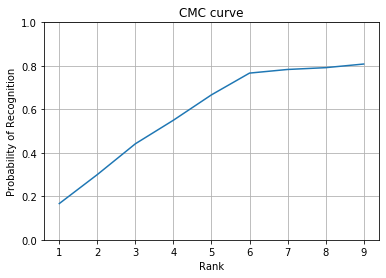

In [20]:
get_cmc_curve(rank_range, avg_probabilities)


## Authentication scenario
Second, we analyse the authentication scenario, which corresponds to 1:1 problem or binary classification. The question that is asked is: “Can you prove who you are?”. A system will challenge someone to prove their identity and the person has to respond in order to allow them access to a system or service. For example, a person touches their finger on a sensor embedded in a smartphone, used by the authentication solution as part of a challenge/response system. "Is it my finger? Yes, then my smartphone is unlocked, or No it isn’t my finger and the smartphone remains locked." [2]

For the authentication scenairo, the data structure for training is slightly different, whereas the test set remains the same. For the training set, the already computed features are divided in separate dictionaries (that act as databases) where the key denotes the class (person), and then every image features for the correspoding class are set in the dictionary as a value.

In [21]:
authentication_databases = prepare_dataset_authentication(train_feature_descriptors)

In [22]:
print('Classes in the training set = {}'.format(authentication_databases.keys()))

Classes in the training set = dict_keys(['101', '102', '103', '104', '105', '106', '107', '108', '109', '110'])


In [23]:
def count_same_fprs(feature_distances, len_best_matches):
    '''
    Counts how many fprs are close to the query fpr
    :param feature_distances: Feature distaces from given query fpr to all training fprs
    :param len_best_matches: Predefined value for the length of best features
    :return count_same: number of same fprs paris within the given len_best_matches
    '''
    count_same = 0
    for features in feature_distances:
        if int(features[1]) > len_best_matches: # Compare the len of best features for the given feature with the predefined len
            count_same += 1
            
    return count_same

In [24]:
def perform_authentication_scenario(dist_threshold, len_best_matches):
    true_y = []
    pred_y = []
    total_distances = []
    print("----- START, Threshold = {} -----".format(dist_threshold))
    for authentication_db_key in authentication_databases.keys():
        authentication_db = authentication_databases[authentication_db_key]
        for test_image_id, test_image in test_set.items():    
            best_matches_dict = get_best_matches(test_image, authentication_db, dist_threshold)
            total_distances.append(best_matches_dict[0])
            
            count_same = count_same_fprs(best_matches_dict, len_best_matches)
            ratio = count_same/len(authentication_db.keys())
            test_image_class = get_image_class(test_image_id)
            true_class = 1 if test_image_class == authentication_db_key else 0
            true_y.append(true_class)
            
            if ratio >= 0.5: 
                pred_y.append(1)
            else:
                pred_y.append(0) 
    
    identical = true_y
    print("Accuracy is %f "%(round(accuracy_score(true_y, pred_y),4)))
    print('The precision score is {}'.format(precision_score(true_y, pred_y)))
    print('F1 score is {}'.format(round(f1_score(true_y, pred_y), 4)))

    return total_distances, identical

Before iterating through different thershold values and length of best matches, we show an example for authenticating one query fingerprint against all fprs databases.

--- For query image: 101_2.tif ---
Probability of correct fpr for class 101 = 1.0


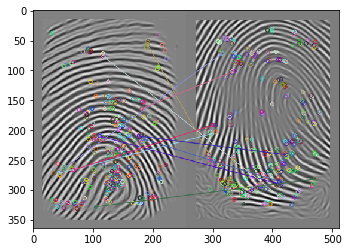

In [32]:
# Example 
test_image_id = list(test_set)[0]
authentication_db = authentication_databases['101']
best_matches_dict = get_best_matches(test_set[test_image_id], authentication_db , 50) 
count_same = count_same_fprs(best_matches_dict, 10)
ratio = count_same/len(authentication_db.keys())
print('--- For query image: {} ---'.format(test_image_id))
print('Probability of correct fpr for class 101 = {}'.format(round(ratio,4)))
draw_keypoints_matches(test_set[test_image_id], train_set['105_1.tif'])

We can notice that there are ~ 83% chances that the person will be correctly authenticated.

In the following code section, we iterate through different threshold values and we accumulate the TPR and FPR for each threshold.



In [26]:
len_best_matches = 15
for dist_threshold in range(30, 70, 10): 
    perform_authentication_scenario(dist_threshold, len_best_matches)

----- START, Threshold = 30 -----
Accuracy is 0.900000 
The precision score is 0.0
F1 score is 0.0
----- START, Threshold = 40 -----


C:\Users\saife\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\saife\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Accuracy is 0.925000 
The precision score is 1.0
F1 score is 0.4
----- START, Threshold = 50 -----
Accuracy is 0.955000 
The precision score is 0.9230769230769231
F1 score is 0.7273
----- START, Threshold = 60 -----
Accuracy is 0.475000 
The precision score is 0.1487603305785124
F1 score is 0.2553


In [27]:
distances, identical = perform_authentication_scenario(50, len_best_matches)
genuine_scores, impostor_scores = get_genuine_impostor_scores(distances, identical)

----- START, Threshold = 50 -----
Accuracy is 0.955000 
The precision score is 0.9230769230769231
F1 score is 0.7273



PyEER is a Python package intended for biometric systems performance evaluation. This package is used for computing the EER, as well as the FAR and FRR later.

EER represents a point where both FAR and FRR are equal.

In [28]:
stats = get_eer_stats(genuine_scores, impostor_scores)
generate_eer_report([stats], ['A'], 'pyeer_report.csv')

In [29]:
eer = round(stats.eer, 4)
print('Equal Error Rate is: {}'.format(eer))

Equal Error Rate is: 0.1528


The evaluation of 1:1 biometric authentication systems is usually done by estimating False Accept Rate (FAR) and False Reject Rate (FRR). Using these estimates, a ROC curve is generated. [1] Compared to the standard ROC curve, where we plot the True Positive Rate (TPR) against the False Positive Rate (FAR), in the domain of biometric sytems, instead of TPR, we plot FRR (or 1 - TPR).

## ROC curve (FAR vs FRR)

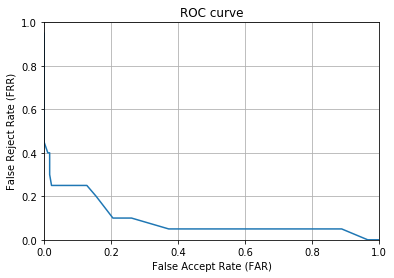

In [30]:
get_roc_curve(stats.fnmr, stats.fmr)